In [15]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import re
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords') 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
stop_words = set(stopwords.words('english'))
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from joblib import load, dump

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Влад\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Влад\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
def check_metrics(history, figure_name):
      train=history.history[f'{figure_name}']
      val = history.history[f'val_{figure_name}']

      epochs = range(1, len(train)+1)
      plt.plot(epochs, train, 'b', label = f'Training {figure_name}')
      plt.plot(epochs, val, label = f'Validation {figure_name}', color = 'green')
      plt.title(f'Training and Validation {figure_name}')
      plt.xlabel('Epochs')
      plt.ylabel(f'{figure_name}')
      plt.legend()
      plt.show()

In [17]:
test=tf.keras.utils.text_dataset_from_directory(r"D:\aclImdb\test")
train=tf.keras.utils.text_dataset_from_directory(r"D:\aclImdb\train")

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [18]:
def extract_rating(filename):
  parts = filename.split('_')
  rating = int(parts[1].split('.')[0])
  return rating

def create_dataframe(folder_path):
  data = []
  for i, subfolder in enumerate(os.listdir(folder_path)):
    subfolder_path = os.path.join(folder_path, subfolder)
    if os.path.isdir(subfolder_path):
      for filename in os.listdir(subfolder_path):
        if filename.endswith(".txt"):
          filepath = os.path.join(subfolder_path, filename)
          with open(filepath, 'r', encoding='utf-8') as file:
            text = file.read()
          rating = extract_rating(filename)
          data.append({'text': text, 'rating': rating, 'label': i})  
  return pd.DataFrame(data)

folder_path = r"D:\aclImdb\test"
folder_path_2=r"D:\aclImdb\train"
test_df = create_dataframe(folder_path)
train_df=create_dataframe(folder_path_2)

print(test_df)

                                                    text  rating  label
0      Once again Mr. Costner has dragged out a movie...       2      0
1      This is an example of why the majority of acti...       4      0
2      First of all I hate those moronic rappers, who...       1      0
3      Not even the Beatles could write songs everyon...       3      0
4      Brass pictures (movies is not a fitting word f...       3      0
...                                                  ...     ...    ...
24995  I was extraordinarily impressed by this film. ...       8      1
24996  Although I'm not a golf fan, I attended a snea...      10      1
24997  From the start of "The Edge Of Love", the view...       8      1
24998  This movie, with all its complexity and subtle...      10      1
24999  I've seen this story before but my kids haven'...       7      1

[25000 rows x 3 columns]


In [19]:
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac = 1)
train_df

,text,rating,label
16038,Writing something genuine and true is challeng...,10,1
21996,This is about a mad scientist who creates a ha...,7,1
8470,This movie was a littttle confusing at first. ...,3,0
18635,this is what i call a great movie. it lives tr...,10,1
23155,"This is a really fun, breezy, light hearted ro...",8,1
...,...,...,...
21068,I am not going to spoil the contents to anyone...,10,1
4279,I have just watched the movie for the first ti...,3,0
8395,Working at a video store I get to see quite a ...,2,0
4999,Worst mistake of my life.<br /><br />I picked ...,1,0


In [20]:
def data_processing(text):
      text = text.lower()
      text = re.sub('<br />', '', text)
      text = re.sub(r"https\S+www\S+https\S+", '', text, flags = re.MULTILINE)
      text = re.sub(r'\@w+|\#', '', text)
      text = re.sub(r'^[\w\s]', '', text)
      text_tokens = word_tokenize(text)
      filtered_text = [w for w in text_tokens if not w in stop_words]
      return " ".join(filtered_text)

In [21]:
train_df.text = train_df['text'].apply(data_processing)
test_df.text = test_df['text'].apply(data_processing)
train_df['text']

16038    riting something genuine true challenging . kn...
21996    mad scientist creates half shark - half man ty...
8470     movie littttle confusing first . usually like ...
18635    call great movie . lives trough fantastic acto...
23155    really fun , breezy , light hearted romantic c...
                               ...                        
21068    going spoil contents anyone , yet watched humb...
4279     watched movie first time . wanted watch like d...
8395     orking video store get see quite movies occasi...
4999     orst mistake life.i picked movie target $ 5 fi...
12155    shallow hedonism and/or social commentary wrap...
Name: text, Length: 25000, dtype: object

In [22]:
duplicated_count = train_df.duplicated().sum()
duplicated_count

98

In [23]:
duplicated_count = test_df.duplicated().sum()
duplicated_count

197

In [24]:
train_df = train_df.drop_duplicates('text')
test_df = test_df.drop_duplicates('text')

In [25]:
X_train = train_df['text']
X_test = test_df['text']
Y_train = train_df['label']
Y_test = test_df['label']
Z_train = train_df['rating']
Z_test = test_df['rating']

In [26]:
vect = TfidfVectorizer()
X_train = vect.fit_transform(train_df['text'])
X_test = vect.transform(test_df['text'])

In [27]:
X_train = X_train[:25000]
X_test =X_test[:25000]
Y_train = Y_train[:25000]
Y_test = Y_test[:25000]
Z_train = Z_train[:25000]
Z_test = Z_test[:25000]

In [28]:
X_train = X_train.toarray()
X_test = X_test.toarray()

In [29]:
optimazer = Adam(learning_rate=0.001)

Epoch 1/15
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 131s 83ms/step - loss: 10.8115 - mse: 10.8115 - val_loss: 4.7666 - val_mse: 4.7666
Epoch 2/15
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 93s 60ms/step - loss: 3.4792 - mse: 3.4792 - val_loss: 4.6736 - val_mse: 4.6736
Epoch 3/15
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 92s 59ms/step - loss: 2.4515 - mse: 2.4515 - val_loss: 4.9522 - val_mse: 4.9522
Epoch 4/15
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 92s 59ms/step - loss: 1.8321 - mse: 1.8321 - val_loss: 5.4627 - val_mse: 5.4627
Epoch 5/15
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 95s 61ms/step - loss: 1.5958 - mse: 1.5958 - val_loss: 5.2303 - val_mse: 5.2303
Epoch 6/15
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 96s 62ms/step - loss: 1.3649 - mse: 1.3649 - val_loss: 5.1825 - val_mse: 5.1825
Epoch 7/15
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 96s 62ms/step - loss: 1.2238 - mse: 1.2238 - val_loss: 5.0859 - val_mse: 5.0859
Epoch 8/15
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 96s 61ms/step - loss: 1.0934 - mse: 1.0934 - val_loss: 5.0662 - val_mse: 5.0662
Epoch 9/15
1557/1557 

C:\Users\Влад\AppData\Local\Temp\ipykernel_148\1331433565.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val, 'b', label = f'Validation {figure_name}', color = 'green')


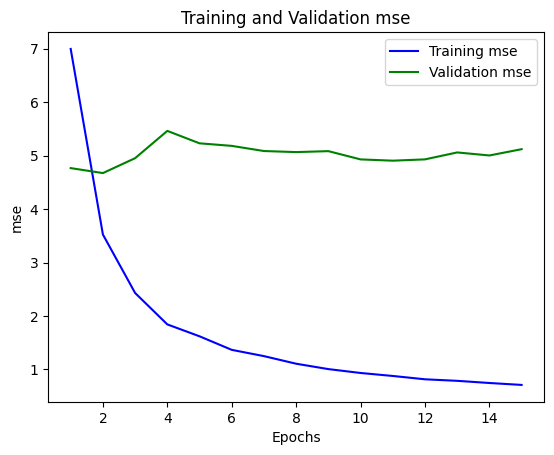

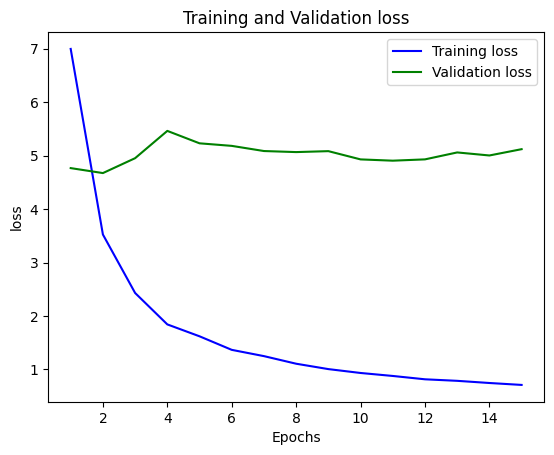

In [30]:
model = Sequential()
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
model.compile(optimizer=optimazer,  loss='mse',  metrics=['mse'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
history = model.fit(x = X_train, y = Z_train, epochs = 15, batch_size=16, validation_data= (X_test, Z_test ))
check_metrics(history, 'mse')
check_metrics(history, 'loss')

In [31]:
dump(model, 'model.joblib')
dump(vect, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 57s 290ms/step - accuracy: 0.6683 - loss: 0.6520 - val_accuracy: 0.8637 - val_loss: 0.4841
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9021 - loss: 0.3984 - val_accuracy: 0.8856 - val_loss: 0.3113
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9325 - loss: 0.2221 - val_accuracy: 0.8874 - val_loss: 0.2756
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9497 - loss: 0.1549 - val_accuracy: 0.8835 - val_loss: 0.2819
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9644 - loss: 0.1130 - val_accuracy: 0.8812 - val_loss: 0.2958
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9768 - loss: 0.0837 - val_accuracy: 0.8756 - val_loss: 0.3219
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9844 - loss: 0.0649 - val_accuracy: 0.8689 - val_loss: 0.3536
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9873 - loss: 0.0524 - val_ac

C:\Users\Влад\AppData\Local\Temp\ipykernel_148\1331433565.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val, 'b', label = f'Validation {figure_name}', color = 'green')


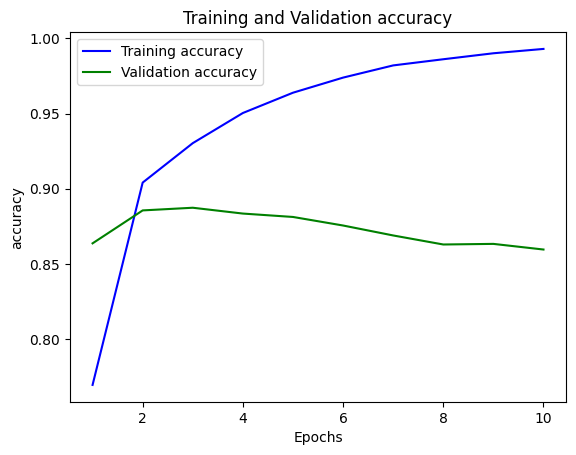

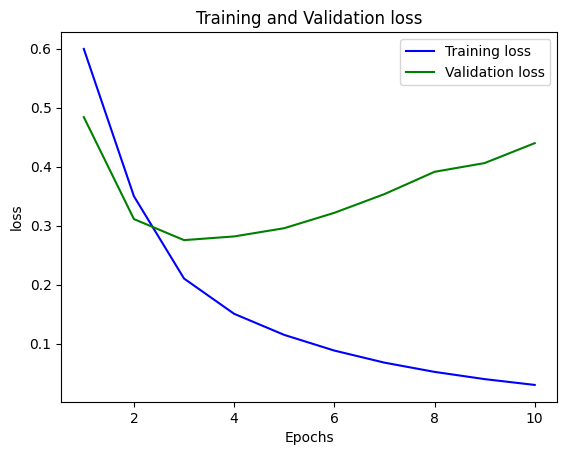

In [32]:
model2 = Sequential()
model2.add(Dense(16, activation='relu'))
model2.add(Dense(8, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='rmsprop',  loss='binary_crossentropy',  metrics=['accuracy'])
history2 = model2.fit(x = X_train, y = Y_train, epochs = 10, batch_size= 128, validation_data= (X_test, Y_test ))
check_metrics(history2, 'accuracy')
check_metrics(history2, 'loss')
